# Xbox Vorlage
Version: 1.1
Stand: 07.12.22


## Einleitung

Dieses Dokument bildet die Grundlage zum python-seitigen Arbeiten mit der Xbox. Dies umfasst das Messen mit der Röntgenkamera und das Bewegen der Stages.

Für die Steuerung der Quelle ist ein separates Programm, sowie eine separate Anleitung notwendig!

## Hinweise zum Umgang mit Jupyter-Notebook

Das Experiment wird mittels eines Jupyter-Notebooks gesteuert. Für die Nutzung werden in diesem Abschnitt einige Hinweise gegeben. 

Bei Jupyter-Notebook handelt es sich um eine Schnittstelle zu einem Python-Prozess.

Der Code wird dabei nacheinander in Zellen ausgeführt. Alternativ lassen sich in den Zellen Schritte kommentieren und Gleichungen aufschreiben. Dafür wird Markdown (https://markdown.de/), LaTeX-Syntax (für Gleichungen bspw. $E=mc^2$) oder HTML verwendet.

Eine neue Zelle kann über den Button 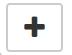 erstellt werden.

Der in einer Zelle aufgeführte Code wird mit ``Shift`` + ``Enter`` ausgeführt. Die dabei erstellten Variablen bleiben für weitere Rechenschritte erhalten.

Einige weitere nützliche Tastenkombinationen sind in der folgenden Tabelle aufgeführt.


Funktion | Tastenkombination
      :--|:---
neue Zelle oberhalb einfügen | ``a`` (im Navigationsmodus)
neue Zelle unterhalb einfügen | ``b`` (im Navigationsmodus)
Löschen einer Zelle | doppelt ``d`` (im Navigationsmodus)
Ausführen einer Zelle | ``Shift`` + ``Enter``

Für weitere Informationen zu Jupyter-Notebook sei beispielsweise auf die folgenden Internetseiten verwiesen:
* https://realpython.com/jupyter-notebook-introduction/
* https://jupyter-notebook.readthedocs.io/en/stable/index.html


## Vorbereitung

### Installationen auf dem Laborcomputer (nur bei Neu-Einrichtung)

Die folgenden Schritte müssen bei der Neueinrichtung des Laborcomputers für das Experiment durchgeführt werden. Nachdem Anaconda installiert wurde müssen folgende Bibliotheken hinzugefügt werden:

* PySerial installieren (für die serielle Kommunikation mit den Motoren)
    * ``conda install -c anaconda pyserial`` 
* imageio installieren (für die Aufnahme von Bildern mit der Kamera)
    * ``conda install -c conda-forge imageio``
* TQDM installieren (für die Anzeige eines Statusbalkens)
    * ``conda install -c conda-forge tqdm``
    
### Vergabe an Rechten für die serielle Kommunikation (nur bei Neu-Einrichtung)

Der Benutzer hat standardmäßig nicht das Recht auf die seriellen/USB-Schnittstellen zuzugreifen. Folgende Befehle fügen ihn zu den entsprechenden Gruppen hinzu. Im Folgenden ist ein Neustart erforderlich, nach diesem erst die Rechte erteilt sind.

* ``sudo usermod -a -G dialout $USER``
* ``sudo usermod -a -G tty $USER``

Kurzfristig kann das Problem auch gelöst werden, in dem dem Benutzer eine spezielle Schnittstelle freigegeben wird. Dies muss jedoch für jede Schnittstelle einzeln erfolgen und die Freigabe erlischt, wenn das USB-Kabel neu verbunden wird.

Exemplarisch für eine Schnittstelle lautet das Kommando, wie folgt:

``sudo chmod a+rw /dev/ttyUSB0``

### Starten des Jupter-Notebooks

* Öffnen eines Terminals (`Strg`+`Alt`+`T`)
* Eingeben: ``jupyter notebook``
* Bestätigen mit ``Enter``

Der automatisch vom Browser geöffnete Link funktioniert in der Regel nicht. Deswegen wird ein anderer Link aus der Befehlzeile in den Browser kopiert. Der entsprechende Link ist Im folgenden Bild unterlegt:

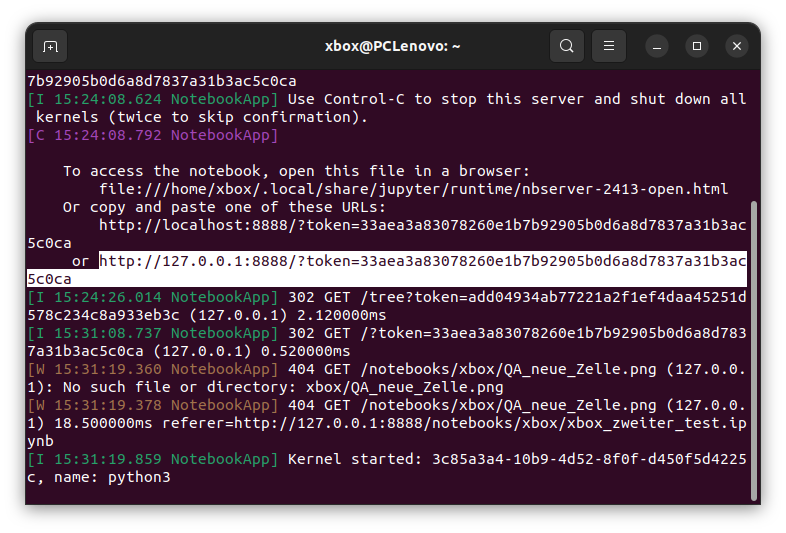

Im Anschluss kann im Browser zum entsprechenden Dokument navigiert werden.


### Definition der Funktionen

In [ ]:
# Kommunikation mit serieller Schnittstelle
import time
import serial
from serial.tools import list_ports
import imageio as iio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os

#--- Funktionen zum Steuern der Stages ---#

# Auslesen und Freimachen des Buffers
# Optional kann der Inhalt ausgegeben werden
def read_complete_buffer(ser,printing=False):
    while(True):
        result = ser.readline()
        if result == b'':
            break
        if printing:
            print(result)

# Schritte mit dem Schrittmotor gehen
def go(ser,steps):
    ser.write(bytes(str(steps),'utf-8'))
    time.sleep(1)
    read_complete_buffer(ser,False)

# Überpüfen ob der Motor beschäftigt ist
def on_target(ser):
    try:
        position(ser)
        return True
    except:
        return False
    
# Schritte mit dem Motor gehen und warten solange der Motor beschäftigt ist.
def go_wait(ser, steps):
    go(ser, steps)
    while not on_target(ser):
        time.sleep(0.5)

# Schritte mit dem Motor gehen und überprüfen, ob der Motor die richtige Endposition erricht hat
# Noch nicht gestestet!
# difference bezeichnet die maximal zulässige Abweichung zur Zielposition
# iterations ist die Anzahl an Zyklen, die versucht wird den Motor zu dieser Position laufen zu lassen,
# falls dieser auf dem Weg gestopppt wird.
def go_check(ser, steps, difference=3, iterations=5):
    current_position = position(ser)
    target_position = current_position+steps
    for iteration in range(iterations):
        remaining_steps = target_position-current_position
        go(ser, remaining_steps)
        while not on_target(ser):
            time.sleep(0.5)
        current_position = position(ser)
        if abs(current_position-target_position) <= difference:
            break
            
def deactivate(ser):
    ser.write(bytes('d','utf-8'))
    time.sleep(1)
    read_complete_buffer(ser,True)
    
def activate(ser):
    ser.write(bytes('a','utf-8'))
    time.sleep(1)
    read_complete_buffer(ser,True)  

# Position abfragen
def position(ser):
    read_complete_buffer(ser,False)
    ser.write(bytes('pos','utf-8'))
    time.sleep(1)
    ser.readline()
    result = ser.readline()
    result = result[9:-2]
    print(result)
    return float(result)
    
# Microstepping einstellen
#  m1 - Setzt den Motor auf ganze Schritte
#  m2 - Halbschritte
#  m4 - Viertelschritte
#  m8 - Achtelschritte
# m16 - Sechzehntelschritte
def microstep(ser,string):
    ser.write(bytes(string,'utf-8'))
    time.sleep(1)
    read_complete_buffer(ser,True)

    
#--- Funktionen zum Aufnehmen und Abscpeicher der Bilder ---#

def shot():
    camera = iio.get_reader("<video0>")
    screenshot = camera.get_data(0)
    camera.close()
    return screenshot

def shot_frames(frames):
    time1 = time.time()
    pic = np.zeros(np.sum(shot(),axis=-1).shape)
    for i in tqdm(range(frames),unit=" Bilder"):
        pic += np.sum(shot(),axis=-1)
    time2 = time.time()
    print("Benötigte Zeit: ",time2-time1," s")
    return pic

def save_tiff(image, filename, path="/home/xbox/Ergebnisse"):
    im = Image.fromarray(image)
    im.save(os.path.join(path,filename)+'.tiff')

### Einrichten der Stages

In [ ]:
# Serielle Schnittstellen anzeigen
schnittstellen = list_ports.comports() 
print('Index \tName')
for i in range(len(schnittstellen)):
    print(i,'\t',schnittstellen[i].device)

In [ ]:
# Herstellen der Verbindung
ser1 = serial.Serial(schnittstellen[1].device, 9600,timeout=1)
ser2 = serial.Serial(schnittstellen[2].device, 9600,timeout=1)
ser3 = serial.Serial(schnittstellen[3].device, 9600,timeout=1)

In [ ]:
# Motor testweise laufen lassen
go(ser3,100)

In [ ]:
# Bennenen der Schnittstellen nach Richtung der Achsen
rot = ser1
laengs = ser2
quer = ser3

In [ ]:
# Alle deaktivieren
deactivate(ser1)
deactivate(ser2)
deactivate(ser3)

In [ ]:
# Alle aktivieren
activate(ser1)
activate(ser2)
activate(ser3)

### Testen der Kamera

In [ ]:
# Aufnehmen eines einzelnen Frames
image = shot()
plt.imshow(image)

In [ ]:
# Aufnehmen mehrerer Frames, über welche summiert wird
image = shot_frames(10)
plt.imshow(image)

In [ ]:
# Speichern eines Bildes mit dem Namen 'Testbild' als .tiff Datei im Ordner
save_tiff(image,'Testbild',path="/home/xbox/Ergebnisse/PG000")

## Tipps und Tricks

### Live-Webcam in 'Cheese'

Beim Bewegen der Stages kann ein Live-Bild der Röntgenkamera hilfreich sein. Dazu kann das Programm Cheese verwenden werden. Es kann wie folgt geöffnet werden:

* klicken auf 'Aktivitäten' (links open in der Ecke)
* 'cheese' eingeben
* auf das Icon klicken

Bevor aus Python die eigentlichen Messungen durchgeführt werden, muss das Programm unebdingt geschlossne werden, da Python sonst keinen Zugriff auf die Kamera hat.

### ImageJ / FIJI

Um die Messungen schnell genauer betrachten zu können empfiehlt es sich diese in FIJI zu öffnen. Hier kann gezoomt und auch der Kontrast angepasst werden. Dazu muss die Messung im Vorhinein als tiff-Datei gespeichert werden (save_tiff).

Nachdem FIJI wie folgt geöffnet wurde:

* klicken auf 'Aktivitäten' (links open in der Ecke)
* 'ImageJ' eingeben
* auf das Icon klicken

kann die tiff Datei per Drag-and-Drop direkt auf das Fenster
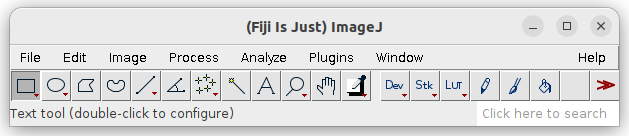
gezogen werden.

Um den Kontrast in einem Bereich des Bildes zu ändern muss dieser augewählt (Recheckiges Auswahl Tool) und mit ``Strg``+``Shift``+``C`` ein Dialog geöffnet werden. Über den ``Auto``-Buttton lässt sich der Konstrast dann ändern.
                    
ImageJ / FIJI bietet noch viele weitere Möglichkeiten, wie beispielsweise eine Rechenumgebung für Bilder (Image Calculator), das Auswerten von Profilen (Plot Profile) oder das Vermessen von Strukturen...

### USB-verbindung

Bei der Verbindung des USB-Hubs mit dem Computer ist unbedingt darauf zu achten eine USB2-Schnittstelle (schwarz) am Computer zu verwenden. Bei der Verwendung einer USB3-Schnittstelle (blau) kommt es zu Problemen bei der Kommunikation mit den Motortreibern und diese bricht ab.

# Bereich der eigenen Messung

In [ ]:
go(rot,18000)

In [ ]:
plt.imshow(shot_frames(25))

In [ ]:
for i in np.arange(0,370,5):
    print(i)
    image = shot_frames(25)
    save_tiff(image,'Scan-'+str(1000+i),path="/home/xbox/Ergebnisse/PG000")
    go(rot,500)